In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as spla
import asymmetric as asym
import quantum as qm
%matplotlib inline
import matplotlib.pyplot as plt
import krypy
import scipy

In [2]:
def get_vec_Haar(N):
    vec = np.random.normal(size=N) + 1j * np.random.normal(size=N)
    norm = la.norm(vec)
    return vec/norm

In [3]:
# def get_otoc_krylov(H, t, v, A, B, m):
#     # Commute the OTOC of A(t), B, approximating by the expectation wrt v
#     # <v| A(t) B A(t) B |v>
#     # Notation: v_a = B v, v_b = A e^(-iHt) B v, etc
    
#     v_a = B @ v
#     ret = krypy.utils.Arnoldi(-1j*H*t, np.array([v_a]).T) # Arnoldi expects a [1,N] vector
#     for i in range(m): ret.advance()
#     V, _ = ret.get()
#     U = la.expm(-1j*V.T.conj()@H@V*t)

#     v_b = A @ V @ U[:,0]
#     ret = krypy.utils.Arnoldi(1j*H*t, np.array([v_b]).T)
#     for i in range(m): ret.advance()
#     V, _ = ret.get()
#     Udag = la.expm(1j*V.T.conj()@H@V*t)

#     v_1 = V @ Udag[:,0]
    
#     ret_c = 

In [4]:
def get_otoc(H, v, A, B, start=None, stop=None, num=None, endpoint=None):
    # Commute the OTOC of A(t), B, approximating by the expectation wrt v
    # <v| A(t) B A(t) B |v>
    # Notation: v_a = B v, v_b = A e^(-iHt) B v, etc
    # ts can be a list of times
    
    v_a = B.dot(v)
    v_b = A.dot(spla.expm_multiply(-1j*H, v_a, start, stop, num, endpoint))
    v_1 =       spla.expm_multiply( 1j*H, v_b, start, stop, num, endpoint)
    
    v_c = A.dot(spla.expm_multiply(-1j*H, v,   start, stop, num, endpoint))
    v_2 = B.dot(spla.expm_multiply( 1j*H, v_c, start, stop, num, endpoint))
#     print(np.shape(v_1))
    
    return (v_2.conj() * v_1).sum(0)

In [14]:
######################################################
# Presets for problem
######################################################
L = 11
H = asym.dense_H(L)
maxiter = 2**L
tol = 10e-10
_, _, _, sig_z_list = qm.get_sigma_lists(L)

In [15]:
######################################################
# Setup for a specific run
######################################################
t = 1
U    = la.expm(-1j*H*t)
Udag = la.expm( 1j*H*t)

/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:243: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:161: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [16]:
v = get_vec_Haar(2**L)
ret = krypy.utils.Arnoldi(-1j*H*t, np.array([v]).T) # Arnoldi expects a [1,N] vector

In [17]:
######################################################
# At time t, try iter iterations until v(t) converges?
# Then use the V_m you've found to make U(t), U^dag(t)
# Once you've done this once, use the same m always
######################################################
true = U@v
current = v
for iter in range(maxiter):
    prev = current
    ret.advance()
    V, h = ret.get()
    U_m = la.expm(-1j*V.T.conj()@H@V*t)
    current = V@U_m[:,0]
#     if (iter%5==0): print(la.norm(true-current))
    if (la.norm(current-prev) < tol): break
m = iter+2
print(m)
print(la.norm(true-current))

27
3.47387118763661e-11


(2048, 27) (27, 26)


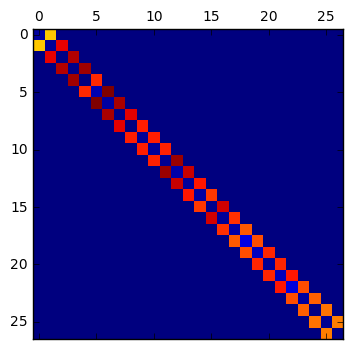

In [18]:
print(np.shape(V), np.shape(h))
plt.matshow(np.absolute(V.T.conj()@H@V)); plt.show()

In [19]:
###################################################
# You can't just use V naively
###################################################
U_m    = la.expm(-1j*V.T.conj()@H@V*t)
Udag_m = la.expm( 1j*V.T.conj()@H@V*t)
i = L//2
Si = sig_z_list[i]
S0 = sig_z_list[0]

# True v_1:
v1 = Udag @ Si @ U @ S0 @ v

# Maybe Krylov approx?
v1_m = V @ Udag_m @ V.T.conj() @ Si @ V @ U_m @ V.T.conj() @ S0 @ v

print(np.absolute(v1-v1_m))

[0.01202442 0.03087469 0.02552932 ... 0.03568364 0.01092346 0.0086453 ]


We want $v_1 = S_1(t)S_0v = e^{iHt}S_1e^{-iHt}S_0v$. 

So define $v_a = S_0v,\; v_b = S_1e^{-iHt}S_0v$. Then we can use Arnoldi to generate $v_b$ and $v_1$. There's a lot of matrix multiplication here but no exponentiation of large matrices.

In [20]:
m = 25
v_a = S0 @ v
ret_a = krypy.utils.Arnoldi(-1j*H*t, np.array([v_a]).T) # Arnoldi expects a [1,N] vector
for i in range(m): ret_a.advance()
V, _ = ret_a.get()
U_m = la.expm(-1j*V.T.conj()@H@V*t)

v_b = Si @ V @ U_m[:,0]
ret_b = krypy.utils.Arnoldi(1j*H*t, np.array([v_b]).T)
for i in range(m): ret_b.advance()
V, _ = ret_b.get()
Udag_m = la.expm(1j*V.T.conj()@H@V*t)

v1_m = V @ Udag_m[:,0]

In [21]:
print(np.absolute(Si@U@S0@v - v_b)[:5])
print(np.absolute(v1-v1_m)[:5])

[1.56038905e-12 1.39036084e-12 4.19659665e-12 1.34047431e-12
 1.98703932e-12]
[3.17393043e-12 3.72757929e-12 1.46460750e-12 3.76730846e-12
 5.59535852e-12]


In [22]:
# We're doing S0(t), Si here

true_otoc = v.T.conj() @ Udag @ S0 @ U @ Si @ Udag @ S0 @ U @ Si @ v
try_otoc  = get_otoc(H, v, S0, Si)
print(true_otoc, try_otoc)

100 loops, best of 3: 10.5 ms per loop
10 loops, best of 3: 46.5 ms per loop


NameError: name 'true_otoc' is not defined

In [ ]:
np.shape(spla.expm_multiply(-1j*H, np.array([v_a,v_a]).T, start=1, stop = 3, num=3))